# Pipelines - Revamped Version


Ce notebook utilise les transformateurs extraits dans le module `src.features` au lieu de les définir inline.

Pour plus d'informations sur la migration, voir [MIGRATION_GUIDE.md](../../MIGRATION_GUIDE.md).

ce notebook sert pour tester le backend des pipelines

# Initialisation

## Imports Librairies

In [1]:
import os
import sys
from tqdm import tqdm
import glob
import numpy as np
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ajouter le répertoire racine du projet au chemin Python
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))

print(project_root)

"""import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
"""

# Import transformers from features module
from src.features.Pipelines.Transformateurs.image_augmentation import *
from src.features.Pipelines.Transformateurs.image_features import *
from src.features.Pipelines.Transformateurs.image_loaders import *
from src.features.Pipelines.Transformateurs.image_preprocessing import *
from src.features.Pipelines.Transformateurs.utilities import *

/home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline


In [2]:
# Vérification que tous les transformateurs sont importés correctement
print("✅ Transformateurs importés avec succès:")
transformers = [
    ImageLoader, ImageResizer, ImageNormalizer, ImageMasker, ImageFlattener,
    ImageBinarizer, ImageAugmenter, ImageRandomCropper, ImageHistogram,
    ImagePCA, ImageStandardScaler, VisualizeTransformer, SaveTransformer
]

for transformer in transformers:
    print(f"  - {transformer.__name__}")

print(f"\n📁 Chemin du projet ajouté: {project_root}")
print(f"📂 Répertoire de travail actuel: {os.getcwd()}")

✅ Transformateurs importés avec succès:
  - ImageLoader
  - ImageResizer
  - ImageNormalizer
  - ImageMasker
  - ImageFlattener
  - ImageBinarizer
  - ImageAugmenter
  - ImageRandomCropper
  - ImageHistogram
  - ImagePCA
  - ImageStandardScaler
  - VisualizeTransformer
  - SaveTransformer

📁 Chemin du projet ajouté: /home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline
📂 Répertoire de travail actuel: /home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline/src/notebooks


## Configs

### Variables Environnement

In [11]:
root_dir = "/home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline/data/raw/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/"

## Definitions

### Fonctions

In [12]:
for label in os.listdir(root_dir):

    print(label)

README.md.txt
Viral Pneumonia
Viral Pneumonia.metadata.xlsx
Normal.metadata.xlsx
Lung_Opacity.metadata.xlsx
Normal
COVID.metadata.xlsx
Lung_Opacity
COVID


In [24]:
print(root_dir)

/home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline/data/raw/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/


In [25]:
class_names = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

In [21]:
def load_paths_data_raw(root_dir):
    image_paths = []
    mask_paths = []
    labels = []

    for cls in class_names:
        class_img_dir = os.path.join(root_dir, cls, 'images')
        class_mask_dir = os.path.join(root_dir, cls, 'masks')
        if os.path.isdir(class_img_dir):
            for img_path in glob.glob(os.path.join(class_img_dir, '*.png')):
                filename = os.path.basename(img_path)
                mask_path = os.path.join(class_mask_dir, filename)
                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
                    labels.append(cls.lower())

    return image_paths, mask_paths, labels

# Main

## Chargement Paths

## Execution Pipeline

In [22]:
X, masks, y = load_paths_data_raw(root_dir)

In [23]:
print(f"Nombre d'images: {len(X)}")
print(f"Labels uniques: {set(y)}")


Nombre d'images: 3616
Labels uniques: {'covid'}


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 2892, Test size: 724


In [11]:
def get_transformer_class(class_name):
    # Cherche la classe dans le scope global
    return globals()[class_name]

def load_pipeline_config(pipeline_file):
    """
    Charge la configuration d'un pipeline depuis un fichier JSON.
    """
    import json
    with open(pipeline_file) as f:
        return json.load(f)

def create_pipeline_from_config(config, masks=None):
    """
    Crée un pipeline scikit-learn à partir d'une configuration JSON.
    Gère les pipelines simples et composites.
    """
    pipeline_type = config.get("type", "simple")
    
    if pipeline_type == "composite":
        return create_composite_pipeline(config, masks)
    else:
        return create_simple_pipeline(config, masks)

def create_simple_pipeline(config, masks=None):
    """
    Crée un pipeline simple à partir des étapes définies.
    """
    steps = []
    for step in config["steps"]:
        cls = get_transformer_class(step["class"])
        params = step["params"]
        if "mask_paths" in params and params["mask_paths"] == "masks" and masks is not None:
            params["mask_paths"] = masks
        steps.append((step["name"], cls(**params)))
    
    return Pipeline(steps, verbose=True)

def create_composite_pipeline(config, masks=None):
    """
    Crée un pipeline composite en combinant d'autres pipelines.
    """
    all_steps = []
    
    for step in config["steps"]:
        if step.get("type") == "pipeline":
            # Charger le sous-pipeline
            sub_config = load_pipeline_config(step["pipeline_file"])
            
            # Filtrer les étapes si nécessaire
            sub_steps = sub_config["steps"]
            if "include_steps" in step:
                sub_steps = [s for s in sub_steps if s["name"] in step["include_steps"]]
            elif "exclude_steps" in step:
                sub_steps = [s for s in sub_steps if s["name"] not in step["exclude_steps"]]
            
            # Ajouter les étapes du sous-pipeline
            for sub_step in sub_steps:
                cls = get_transformer_class(sub_step["class"])
                params = sub_step["params"]
                if "mask_paths" in params and params["mask_paths"] == "masks" and masks is not None:
                    params["mask_paths"] = masks
                all_steps.append((f"{step['name']}_{sub_step['name']}", cls(**params)))
        
        else:
            # Étape normale
            cls = get_transformer_class(step["class"])
            params = step["params"]
            if "mask_paths" in params and params["mask_paths"] == "masks" and masks is not None:
                params["mask_paths"] = masks
            all_steps.append((step["name"], cls(**params)))
    
    return Pipeline(all_steps, verbose=True)

# Chargement du registry des pipelines
registry_config = load_pipeline_config(os.path.join(project_root, "src/features/Pipelines/Configs_Pipelines/pipeline_config.json"))
print("Pipelines disponibles:")
print("=" * 50)

# Organiser par catégorie
categories = {}
for name, info in registry_config.items():
    # Ignorer les métadonnées
    if name in ["description"]:
        continue
    
    if isinstance(info, dict) and "category" in info:
        category = info.get("category", "other")
        if category not in categories:
            categories[category] = []
        categories[category].append((name, info))

# Afficher par catégorie
for category, pipelines in sorted(categories.items()):
    print(f"\nCatégorie: {category.upper()}\n")
    for name, info in pipelines:
        status = "(par défaut)" if name == "default" else ""
        print(f"  {name}: {info['description']} {status}")
        print(f"     Fichier: {info['file']}\n")

Pipelines disponibles:

Catégorie: COMPOSITE

  composite: Exemple de pipeline composite avec visualisation 
     Fichier: ../../src/features/Pipelines/Configs_Pipelines/pipeline_composite_example.json

  composite_no_viz: Pipeline composite sans visualisation (plus rapide) 
     Fichier: ../../src/features/Pipelines/Configs_Pipelines/pipeline_composite_no_viz.json


Catégorie: DATA_PROCESSING

  default: Pipeline simple et rapide (par défaut)
     Fichier: ../../src/features/Pipelines/Configs_Pipelines/pipeline_simple.json

  simple: Pipeline simple et rapide 
     Fichier: ../../src/features/Pipelines/Configs_Pipelines/pipeline_simple.json

  augmented: Pipeline avec augmentation et masquage 
     Fichier: ../../src/features/Pipelines/Configs_Pipelines/pipeline_augmented.json


Catégorie: FEATURE_ENGINEERING

  feature_engineering: Pipeline avec feature engineering avancé 
     Fichier: ../../src/features/Pipelines/Configs_Pipelines/pipeline_feature_engineering.json



In [12]:
def load_pipeline_by_name(pipeline_name, masks=None):
    """
    Charge un pipeline par son nom depuis le registry.
    """
    registry_config = load_pipeline_config("../../src/features/Pipelines/Configs_Pipelines/pipeline_config.json")
    
    # Filtrer les métadonnées
    available_pipelines = {k: v for k, v in registry_config.items() 
                          if isinstance(v, dict) and "file" in v}
    
    if pipeline_name not in available_pipelines:
        available = list(available_pipelines.keys())
        raise ValueError(f"Pipeline '{pipeline_name}' non trouvé. Disponibles: {available}")
    
    pipeline_file = available_pipelines[pipeline_name]["file"]
    pipeline_config = load_pipeline_config(pipeline_file)
    
    print(f"Chargement du pipeline: {pipeline_config['name']}")
    print(f"Description: {pipeline_config['description']}")
    
    return create_pipeline_from_config(pipeline_config, masks)

# Exemple d'utilisation :
# pipeline_simple = load_pipeline_by_name("simple", masks)
# pipeline_augmented = load_pipeline_by_name("augmented", masks)
# pipeline_composite = load_pipeline_by_name("composite", masks)

# Chargement du pipeline par défaut
default_pipeline_name = "default"  # Le pipeline par défaut est maintenant appelé "default"
default_config = load_pipeline_config(registry_config[default_pipeline_name]["file"])
pipeline = create_pipeline_from_config(default_config, masks)

print(f"\nPipeline par défaut chargé: {default_config['name']}")
print(f"Description: {default_config['description']}")
print(f"Nombre d'étapes: {len(pipeline.steps)}")


Pipeline par défaut chargé: pipeline_simple
Description: Pipeline simple pour classification rapide
Nombre d'étapes: 5


In [13]:
# Entraînement du pipeline composite
pipeline.fit(X_train, y_train)

# Prédiction
y_pred = pipeline.predict(X_test)


Chargement de 2892 images...


Images:   0%|          | 0/2892 [00:00<?, ?it/s]

Images: 100%|██████████| 2892/2892 [00:03<00:00, 841.49it/s]


Chargement terminé.

[Pipeline] ........ (step 1 of 5) Processing img_loader, total=   3.5s

Redimensionnement de 2892 images en [256, 256] ...


Redimensionnement: 100%|██████████| 2892/2892 [00:01<00:00, 1864.63it/s]


Redimensionnement terminé.

[Pipeline] ....... (step 2 of 5) Processing img_resizer, total=   1.7s

Normalisation de 2892 images ...
Normalisation terminée.

[Pipeline] .... (step 3 of 5) Processing img_normalizer, total=   5.3s

Aplatissement de 2892 images ...


Aplatissement: 100%|██████████| 2892/2892 [00:00<00:00, 8698.47it/s] 


Aplatissement terminé.

[Pipeline] ....... (step 4 of 5) Processing img_flatten, total=   1.3s


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.str_('covid')

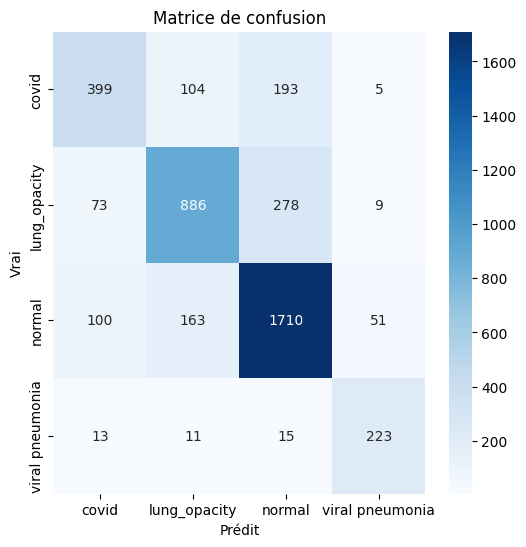

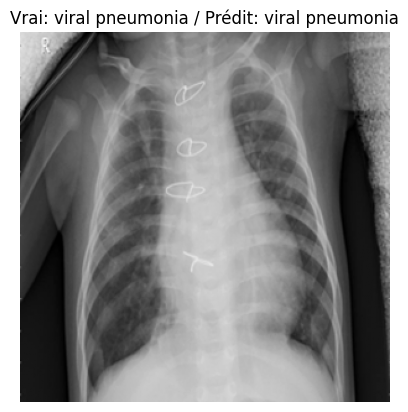

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion visuelle
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()

# Afficher quelques images test avec prédiction et vrai label
for i in range(10):
    img = Image.open(X_test[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"Vrai: {y_test[i]} / Prédit: {y_pred[i]}")
    plt.axis('off')
    plt.show()